# Description:
Given the rough location of an event, download data for this event for stations meeting a certain epicentral distance criteria.

# Setups

In [25]:
from obspy.clients.fdsn import Client
from obspy.core.event import Origin
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy.io.sac.sactrace import SACTrace
from obspy import read_inventory, UTCDateTime
from obspy import read

import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib notebook

### Choose:

In [36]:
# web service client:
client = Client("IRIS")

# Earth model:
model = TauPyModel(model='ak135')

# folder for this event:
directory = '/Users/23brianc/Documents/Internship2020/Data/'

# directory to download raw data:
raw_directory = directory+'raw/'

# directory to store instrument-corrected data:
corrected_directory = directory+'corrected/'

%mkdir /Users/23brianc/Documents/Internship2020/Code/Data/
%mkdir /Users/23brianc/Documents/Internship2020/Code/Data/raw/
%mkdir /Users/23brianc/Documents/Internship2020/Code/Data/corrected/

mkdir: /Users/23brianc/Documents/Internship2020/Code/Data/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Code/Data/raw/: File exists
mkdir: /Users/23brianc/Documents/Internship2020/Code/Data/corrected/: File exists


In [37]:
# pre-filter for removing instrument response:
prefilt = (0.05,0.1,10,20)

def detrend_and_remove_response(stream,window):
    for tr in stream:
        tr.detrend(type='constant')  # de-mean
        tr.detrend(type='linear')
        tr.remove_response(output='VEL',taper = True, taper_fraction = 0.05,pre_filt= window, water_level = 60.0)
    return stream

# Search for stations given an event

In [38]:
# search for stations certain distance away from event
station_search_lower_range=kilometer2degrees(200)  #in km
station_search_upper_range=kilometer2degrees(2000)

In [39]:
# event location: latitude and longitude
evla = 36.232
evlo = 77.916

# search timeframe
starttime = UTCDateTime("2005-06-20T22:00:00")
endtime = UTCDateTime("2005-06-20T23:59:59")

# station inventory
inventory = client.get_stations(level='response',channel='BH*',starttime=starttime,endtime=endtime,latitude=evla,
                               longitude=evlo, minradius=station_search_lower_range,
                                maxradius=station_search_upper_range)
inventory.write(directory+"inventory.xml",format='STATIONXML')
# inventory[x][y] gives you station y in network x

#### plot a station map if you want to

<IPython.core.display.Javascript object>


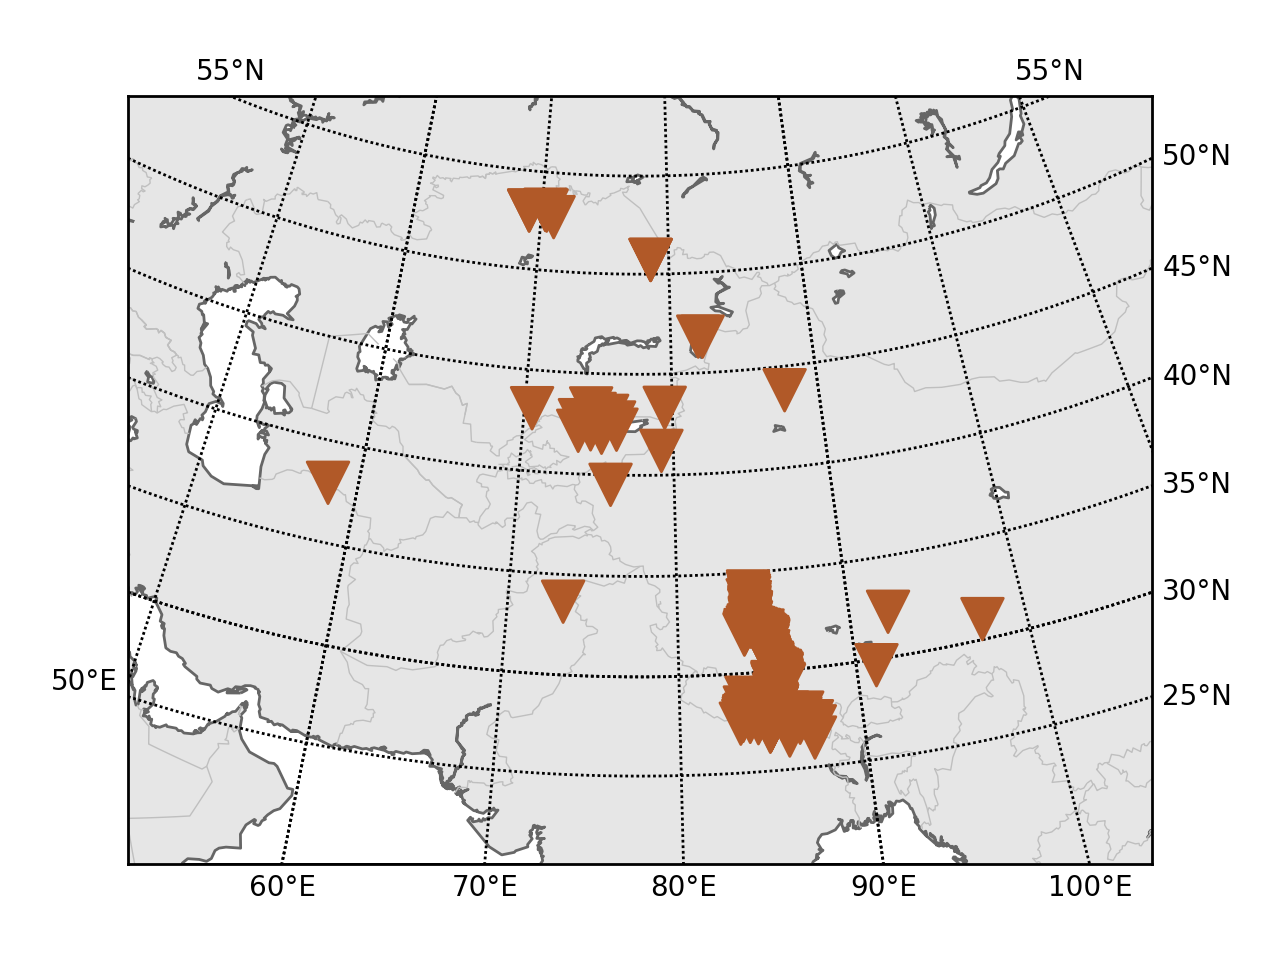

In [40]:
stn_map = inventory.plot(projection="local",show=False)

# Let the computer know the event

In [41]:
event_search_max_radius = kilometer2degrees(200) #in km

In [42]:
catalogue = client.get_events(starttime=starttime,endtime=endtime,latitude=evla,longitude=evlo,
                              maxradius=event_search_max_radius, minmagnitude=3,mindepth=60)
print(catalogue)

1 Event(s) in Catalog:
2005-06-20T22:52:26.530000Z | +36.260,  +78.074 | 3.9 mb


#### Get event information

In [43]:
event_info = catalogue.events[0].origins[0]
origin_time = event_info.time
evlo = event_info.longitude
evla = event_info.latitude
evdp = event_info.depth

yr = origin_time.year
jd = origin_time.julday
hr = origin_time.hour
mins = origin_time.minute
sec = origin_time.second
msec = origin_time.microsecond

# convert event depth to km if necessary
if evdp > 1000:
    evdp = evdp / 1000

#### Plot a station-event map if you want to (not working now)

<IPython.core.display.Javascript object>


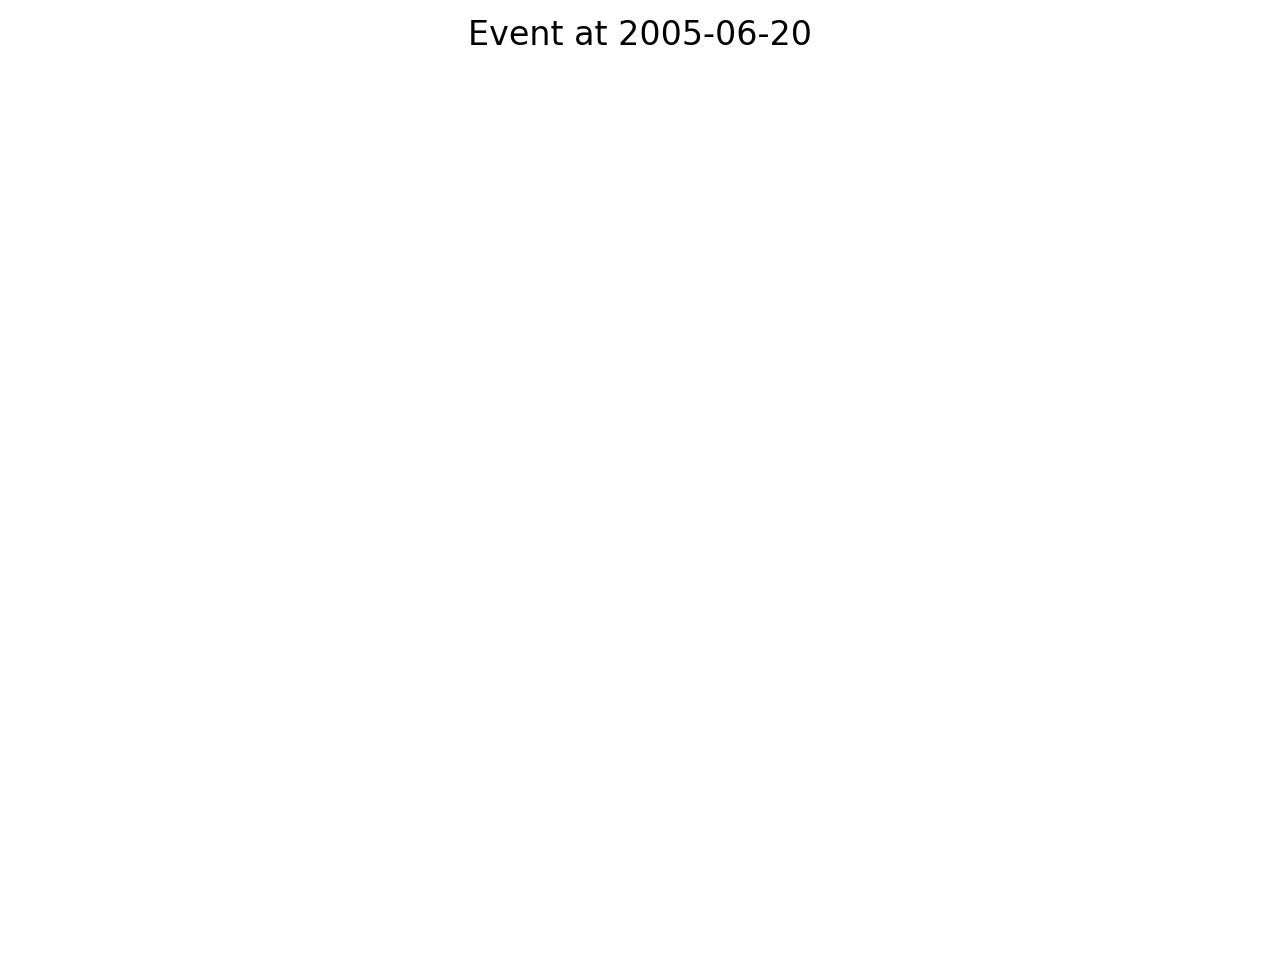

In [44]:
catalogue.plot(fig=stn_map);

# Loop over each station in each network to request data

In [45]:
for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 1000
        seconds_after_P = P_arrival_time_at_stn + 2000
        
        try:
            stream = client.get_waveforms(net.code,stn.code,'*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
        except:
            print('No Data'+' for station '+net.code+'.'+stn.code+' !!')
            continue

        number_of_traces = len(stream)
        number_of_locs = int(len(stream)/3)
        print('Found '+str(number_of_traces)+' traces for station '+net.code+'.'+stn.code)
        
        # remove mean, linear trend and instrument response
        try:
            corrected_stream = detrend_and_remove_response(stream,prefilt);
        except Exception as e:
            print('Cannot correct for station '+net.code+'.'+stn.code+' !!'+' due to ', e)
            continue
        
        # write raw data
        for tr in stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = raw_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)
        
        # write corrected data
        for tr in corrected_stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = corrected_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)

No Data for station CB.CAD !!
No Data for station CB.KSH !!
No Data for station CB.NAQ !!
No Data for station G.WUS !!
Found 6 traces for station IC.LSA
Found 6 traces for station IC.WMQ
Found 3 traces for station II.AAK
Found 3 traces for station II.ABKT
No Data for station II.BRVK !!
Found 3 traces for station II.KURK
Found 3 traces for station II.NIL
Found 9 traces for station KN.AAK
Found 3 traces for station KN.AML
Found 3 traces for station KN.CHM
Found 3 traces for station KN.EKS2
Found 3 traces for station KN.KBK
Found 15 traces for station KN.KZA
No Data for station KN.NRPT !!
Found 3 traces for station KN.TKM2
Found 3 traces for station KN.UCH
Found 3 traces for station KN.ULHL
Found 3 traces for station KN.USP
No Data for station KZ.BRVK !!
Found 3 traces for station KZ.BVAR
Found 3 traces for station KZ.KKAR
Cannot correct for station KZ.KKAR !! due to  check_channel: Illegal RESP format
No Data for station KZ.KUR !!
No Data for station KZ.KURK !!
No Data for station KZ.MAK

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


No Data for station KZ.ZRN !!
Found 3 traces for station KZ.ZRNK


/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


No Data for station XF.H0010 !!
No Data for station XF.H0020 !!
No Data for station XF.H0030 !!
No Data for station XF.H0040 !!
No Data for station XF.H0050 !!
No Data for station XF.H0060 !!
No Data for station XF.H0070 !!
No Data for station XF.H0080 !!
No Data for station XF.H0090 !!
No Data for station XF.H0100 !!
No Data for station XF.H0120 !!
No Data for station XF.H0130 !!
No Data for station XF.H0150 !!
No Data for station XF.H0160 !!
No Data for station XF.H0170 !!
No Data for station XF.H0180 !!
No Data for station XF.H0190 !!
No Data for station XF.H0200 !!
No Data for station XF.H0210 !!
No Data for station XF.H0220 !!
No Data for station XF.H0230 !!
No Data for station XF.H0240 !!
No Data for station XF.H0250 !!
No Data for station XF.H0260 !!
No Data for station XF.H0270 !!
No Data for station XF.H0280 !!
No Data for station XF.H0290 !!
No Data for station XF.H0310 !!
No Data for station XF.H0320 !!
No Data for station XF.H0330 !!
No Data for station XF.H0340 !!
No Data 

### Quick preview of downloaded data

In [46]:
raw_st = read(raw_directory+'*')
corrected_st = read(corrected_directory+'*')

<IPython.core.display.Javascript object>


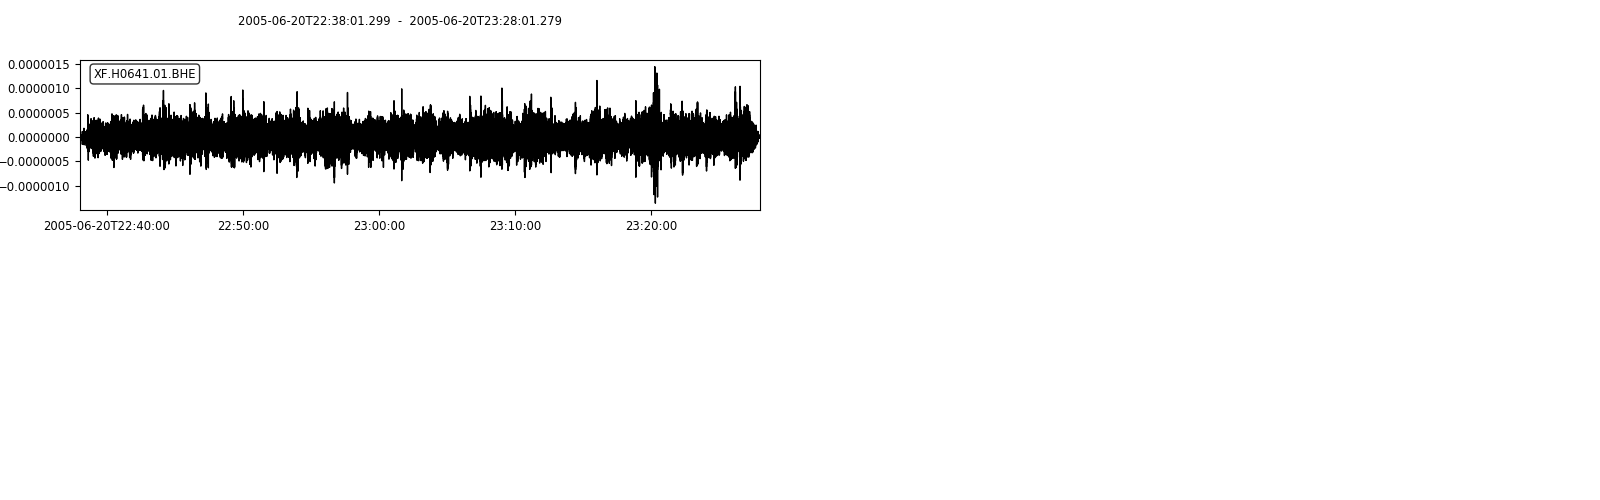

<IPython.core.display.Javascript object>


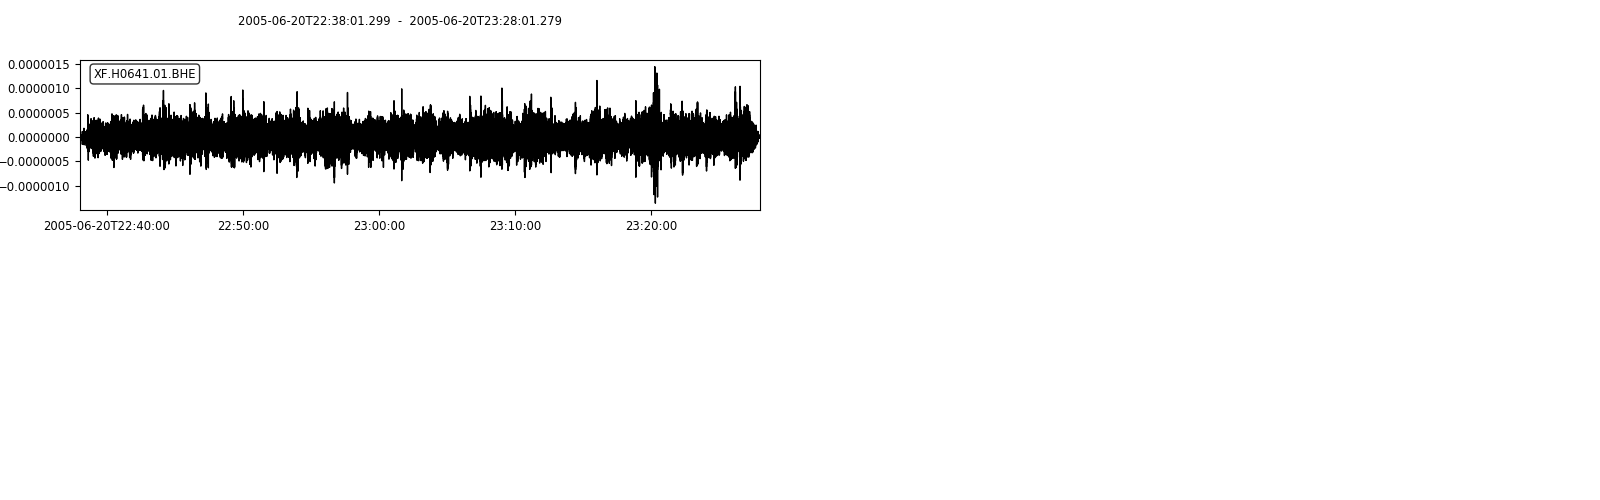

In [63]:
index = 66

raw_st[index].plot();
corrected_st[index].plot();

# Play around with individual case

In [49]:
stn = inventory[6][40]
stla = stn.latitude
stlo = stn.longitude
geo = gps2dist_azimuth(stla,stlo,evla,evlo)
epi_dist = geo[0]/1000. #in km
baz = geo[1]
gcarc = kilometer2degrees(epi_dist) # convert arc length to angle

In [50]:
model = TauPyModel(model='ak135')
arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])

In [51]:
P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
seconds_before_P = P_arrival_time_at_stn - 1000
seconds_after_P = P_arrival_time_at_stn + 2000

In [52]:
try:
    data = client.get_waveforms('G','WUS','*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
except:
    print('No Data!')

number_of_traces = len(data)
number_of_locs = int(len(data)/3)
print('Find '+str(number_of_traces)+' traces for station')  

No Data!


NameError: name 'data' is not defined

In [ ]:
data.plot();

In [ ]:
detrend_and_remove_response(data,prefilt);
data.plot();

In [ ]:
inventory[-1][61]